# SysArmy Surveys: Analysis of argentine techies' salaries evolution

## Datasets

The used datasets have been published on SysArmy's blog since they started taking the surveys.  Each survey contains differencies on their columns, mostly additions across the time, but some names and order have changed to.

In order to normalize the different structures, the next section includes a
 couple of functions to facilitate this process.  Below, is the list of datasets used at the moment.

### Salaries
 
| Period  | Path             | URL                                                                                                         |
|---------|------------------|-------------------------------------------------------------------------------------------------------------|
| 2014.02 | data/2014.02.csv | http://sysarmy.com.ar/blog/wp-content/uploads/2015/01/sysarmy-resultados-encuesta-remuneracion-salarial.csv |
| 2015.01 | data/2015.01.csv | http://sysarmy.com.ar/blog/wp-content/uploads/2015/09/sysarmy-encuesta-salarial-julio-2015.csv              |
| 2016.01 | data/2016.01.csv | https://sysarmy.com.ar/blog/wp-content/uploads/2016/02/sysarmy-encuesta-salarial-enero-2016.csv             |
| 2016.02 | data/2016.02/    | https://sysarmy.com.ar/blog/wp-content/uploads/2016/08/encuesta-sueldos-sysarmy-openqube.zip                |
| 2017.01 | data/2017.01/    | https://docs.google.com/spreadsheets/d/1diZG7ruHJ4OgO2-tbnO-ZnhjxjOnYjMVSxl7I-4LT54/edit#gid=1424918437     |
| 2017.02 | -                | -                                                                                                           |
### Argentine Peso AR\$ to US\$

| Period  | Path                 | URL                                                                                                     |
|---------|----------------------|---------------------------------------------------------------------------------------------------------|
| 5Y      | data/usdars-cur.json | https://www.bloomberg.com/markets/api/bulk-time-series/price/USDARS%3ACUR?timeFrame=5_YEAR              |


## Data preparation

### Outliers removal

There's some noise on the data caused intentionally or unintentionally, but wrong data at the end, such as salaries tending to infinity, negative, etc.

In [157]:
import pandas as pd
import numpy as np
import re
from matplotlib import cm
from functools import reduce
from IPython.display import display, Markdown as md

def getPeriodDF(period, publish_date, csv_path, columns_src, columns_dst, transforms = []):
    # given a csv_path, extract src columns into dst columns by applying a transform function for a certain period name
    df_src = pd.read_csv(csv_path)
    df_dst = pd.DataFrame(columns=['period', 'publish_date']+columns_dst)
    df_dst[columns_dst] = df_src[columns_src]
    df_dst['period'] = period
    df_dst['publish_date'] = pd.to_datetime(publish_date)
    # apply custom transformations
    for transform in transforms:
        df_src, df_dst = transform(df_src, df_dst)
    return df_dst

def transformNormalize(df_src, df_dst):
    # cast to float the salary column, some datasets gets wrongly parsed due to crappy user input
    df_dst['salary'] = df_dst['salary'].astype(float)
    # normalize stack column
    re_separator = ' *, *| *; *| *\. *| *\| *| *\/ *| *- *'
    re_garbage = '"""|\*|nan|='
    df_dst['stack'] = df_dst['stack'].apply(lambda s: re.split(re_separator, re.sub(re_garbage, '', str(s)).strip().lower()))
    # munge the dataset, removing entries that we consider not realistic for our analysis
    munging_mask = (df_dst.salary > 5000) & (df_dst.salary < 300000)
    df_src = df_src.loc[munging_mask]
    df_dst = df_dst.loc[munging_mask]
    return df_src, df_dst

def transformNet2Brute(df_src, df_dst):
    # filter wether net or brute income
    mask = np.array(df_src['Bruto o neto?'].str.contains('Neto'), dtype = bool)
    net_factor = np.array([1.0] * len(df_dst));
    # scales up net salary into brute, given Argentina's social security contributions
    net_factor[ mask ] = 1/0.83
    df_dst['salary'] = net_factor * df_dst['salary']
    return df_src, df_dst

src_common_cols = [
    'Años de experiencia',
    'Años en el puesto actual',
    'Trabajo de',
    'Tecnologías que utilizás']

dst_cols = [
    'salary',
    'yoe',
    'yip',
    'role',
    'stack']

df1 = getPeriodDF('2014.02', '2015-01-01', '../data/2014.02.csv', 
                  ['Salario bruto mensual (AR$)'] + src_common_cols, dst_cols, 
                  [transformNormalize])

df2 = getPeriodDF('2015.01', '2015-09-01', '../data/2015.01.csv', 
                  ['Salario bruto mensual (AR$)'] + src_common_cols, dst_cols, 
                  [transformNormalize])

df3 = getPeriodDF('2016.01', '2016-02-01', '../data/2016.01.csv', 
                  ['Salario mensual (AR$)'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df4 = getPeriodDF('2016.02', '2016-08-01', '../data/2016.02/argentina.csv', 
                  ['Salario mensual (en tu moneda local)'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

df5 = getPeriodDF('2017.01', '2017-02-01', '../data/2017.01/argentina.csv', 
                  ['Salario mensual (en tu moneda local)'] + src_common_cols, dst_cols, 
                  [transformNormalize, transformNet2Brute])

# get the union of all the datasets
df = pd.concat([df1, df2, df3, df4, df5])

# extract the list of periods
periods = df.period.unique()

# generate a list of colors by period for easy visualization on next figures
colors = cm.rainbow(np.linspace(0, 1, len(periods)))

# extract the list of stacks
all_stacks = reduce(lambda res, it: np.concatenate((res, it)), df['stack'], np.array([]))
data = np.transpose(np.unique(all_stacks, return_counts=True))
dfs = pd.DataFrame(data, columns=['stack', 'count'])
dfs['count'] = dfsc['count'].astype(int)
dfs = dfsc.query('count > 100 & stack != ""').sort_values(by=['count'], ascending=[0])

# create a dataframe with the mosted frequent stack names and mask of rows in main df matching it
dfs['df_mask'] = dfs['stack'].apply(lambda stack: np.array(df['stack'].apply(lambda s: np.isin(stack, s))))

# show results
display(md('# Curated data'))
display(md('## Survey entries'))
display(df)
display(md('## Stack names, frquency and entries mask'))
display(dfs)

# Curated data

## Survey entries

,period,publish_date,salary,yoe,yip,role,stack
0,2014.02,2015-01-01,21000.000000,5 - 7,Menos de un año,SysAdmin,"[linux, cloud]"
1,2014.02,2015-01-01,10000.000000,10+,2 - 4,SysAdmin,[linux]
2,2014.02,2015-01-01,16000.000000,3 - 5,1 - 2,DevOps,"[linux, cloud]"
3,2014.02,2015-01-01,23771.130000,5 - 7,1 - 2,SysAdmin,[linux]
4,2014.02,2015-01-01,16000.000000,10+,2 - 4,DevOps,[linux]
5,2014.02,2015-01-01,17000.000000,7 - 10,1 - 2,PM,[]
6,2014.02,2015-01-01,17250.000000,5 - 7,6 - 10,Networking,[]
7,2014.02,2015-01-01,11000.000000,7 - 10,2 - 4,Otro,[]
8,2014.02,2015-01-01,19176.000000,5 - 7,1 - 2,Infosec,[]
9,2014.02,2015-01-01,9600.000000,3 - 5,Menos de un año,DevOps,[linux]


## Stack names, frquency and entries mask

,stack,count,df_mask
664,windows,4499,"[False, False, False, False, False, False, Fal..."
300,linux,3480,"[True, True, True, True, True, False, False, F..."
645,vmware,1882,"[False, False, False, False, False, False, Fal..."
120,containers,621,"[False, False, False, False, False, False, Fal..."
148,docker,621,"[False, False, False, False, False, False, Fal..."
26,amazon web services,489,"[False, False, False, False, False, False, Fal..."
58,azure,421,"[False, False, False, False, False, False, Fal..."
549,solaris,372,"[False, False, False, False, False, False, Fal..."
75,bsd,314,"[False, False, False, False, False, False, Fal..."
21,aix,298,"[False, False, False, False, False, False, Fal..."


## Histogram of Incomes by period (Argentina)

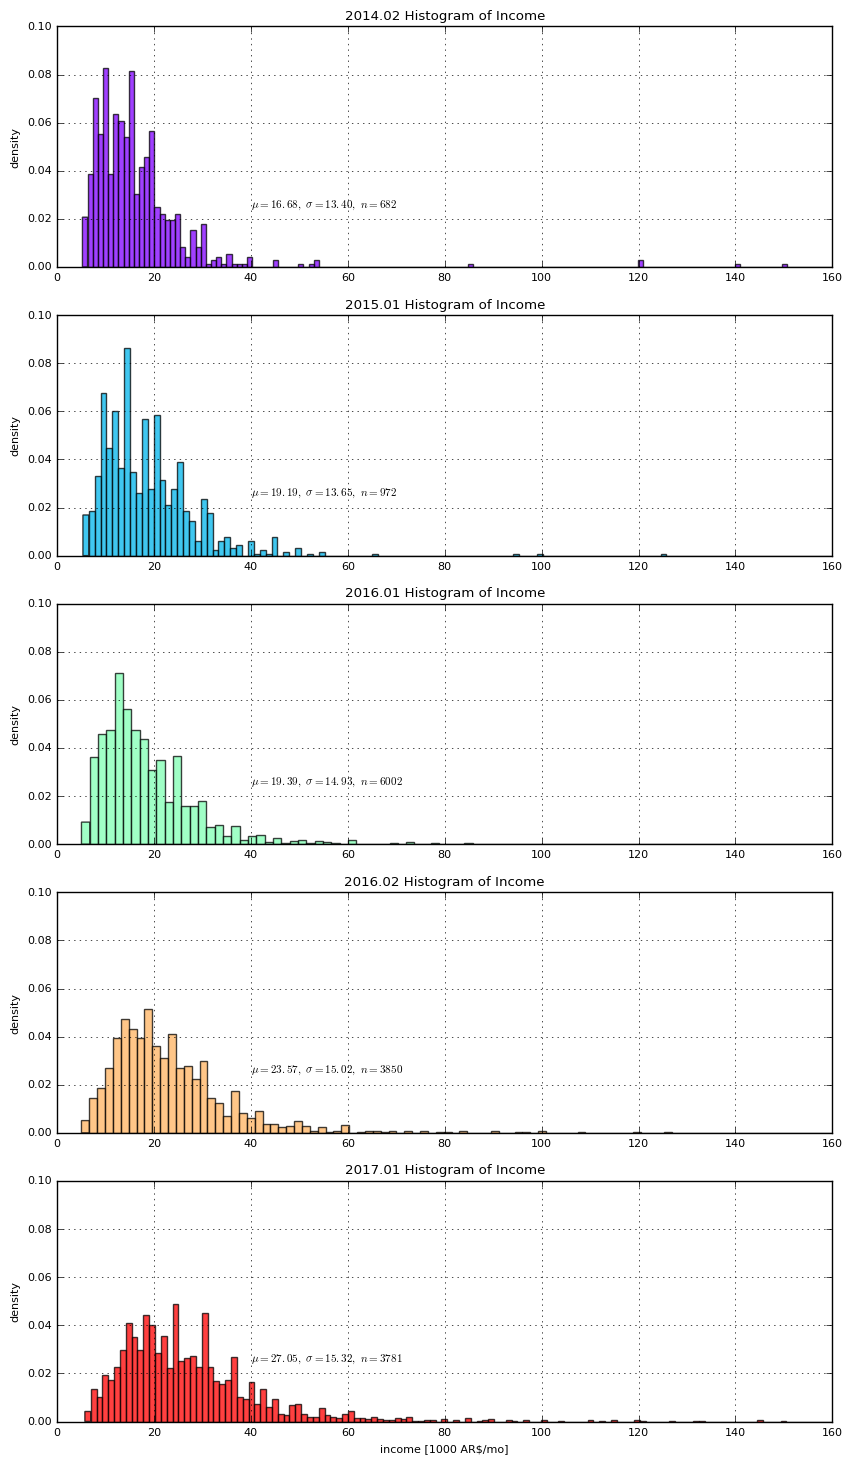

In [110]:
import scipy.stats as sps
import matplotlib.pyplot as plt

def getPlotSalarySeries(currencySeries):
    s = currencySeries.apply(lambda x: float('{0:.2f}'.format(round(x/1000, 1))))
    mu, sigma = np.mean(s), np.std(s)
    t = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
    d = sigma**2/mu
    return mu, sigma, t, d, s

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 18.0), 'font.size': 8})
fig, ax = plt.subplots(len(periods), 1)
for i, period in enumerate(periods):
    dft = df[df['period'] == period]
    mu, sigma, t, d, s = getPlotSalarySeries(dft.salary)
    n, bins, patches = ax[i].hist(s, 160, normed=1, alpha=0.75, color=colors[i])
    ax[i].set_ylabel('density')
    ax[i].set_title(period + ' Histogram of Income')
    ax[i].text(40, .025, '$\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)))
    ax[i].axis([0, 160, 0, 0.1])
    ax[i].grid(True)
ax[len(periods)-1].set_xlabel('income [1000 AR$/mo]')
fig.canvas.draw()

## Median and Standard deviation evolution

Note that in `2016.01`, the median seems to be abnormal.  We're pending to check the data integrity, but as for the histogram, it looks legit.  Perhaps this singularity has to do with the contraction of the economy caused by the persidential elections and the economy uncertainty.

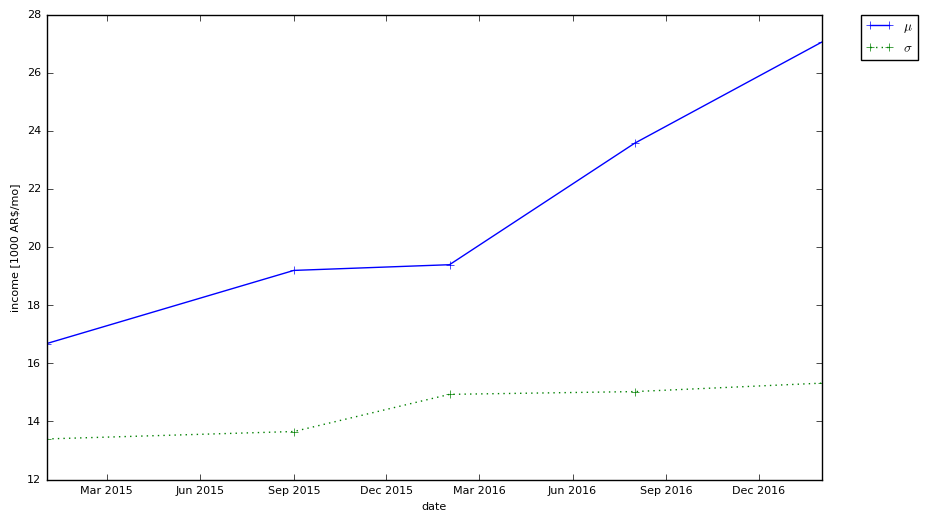

In [237]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
mus, sigmas, dates = [], [], []
for period in periods:
    dft = df[df.period.str.contains(period)]
    mu, sigma, t, d, s = getPlotSalarySeries(dft.salary)
    mus.append(mu)
    sigmas.append(sigma)
    dates.append(dft.publish_date[0])
    
plt.plot(dates, mus, '+', label='$\mu$', ls='-', c='b')
plt.plot(dates, sigmas, '+', label='$\sigma$', ls=':', c='g')
plt.xlabel('date'); plt.ylabel('income [1000 AR$/mo]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Currency evolution (Argentine Peso)

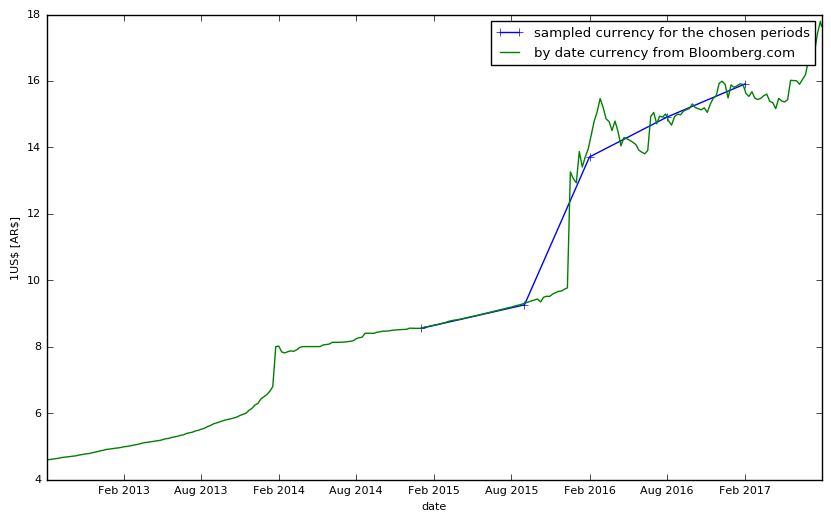

In [229]:
import json
import datetime
with open('../data/usdars-cur.json') as data_file:    
    data = json.load(data_file)  
    df_currency = pd.DataFrame(data[0]['price'])
    df_currency.date = pd.to_datetime(df_currency.date)

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
delta = datetime.timedelta(days=15)
currencies = []
for date in dates:
    currency_series = df_currency[(df_currency.date >= date-delta) & (df_currency.date <= date+delta)]
    currencies.append(float(currency_series.value[:1]))

plt.xlabel('date'); plt.ylabel('1US\$ [AR\$]')
plt.plot(dates, currencies, '+', label='sampled currency for the chosen periods', ls='-', c='b')
plt.plot(df_currency.date, df_currency.value, label='by date currency from Bloomberg.com', ls='-', c='g')
plt.legend()

## Monthly nominal GDP

Monthly Gross Domestic Product, in US dollars, tell us the purchasing capacity of Argentines salaries in nominal values.  To ompute the values, we just divide each $\mu$ by the dollar rate at its given moment.

The results can be compared with World Bank data for Argebtina provided here:

http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2016&locations=AR&start=2010

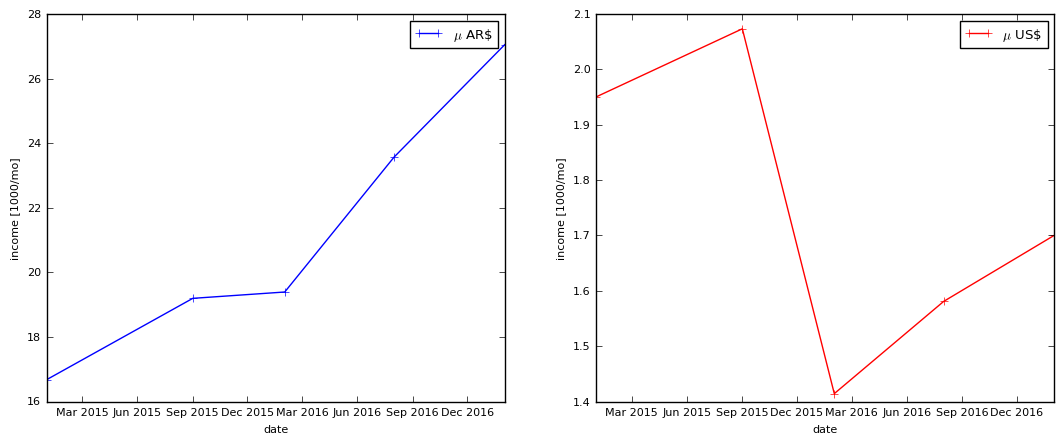

In [236]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (13.0, 5.0), 'font.size': 8})

fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel('date'); ax[0].set_ylabel('income [1000/mo]')
ax[0].plot(dates, mus, '+', label='$\mu$ AR\$', ls='-', c='b')
ax[0].legend()

ax[1].set_xlabel('date'); ax[1].set_ylabel('income [1000/mo]')
ax[1].plot(dates, np.divide(mus, currencies), '+', label='$\mu$ US\$', ls='-', c='r')
ax[1].legend()

fig.canvas.draw()

![](https://media.giphy.com/media/26BkO8zeNfyXvw2Xu/giphy.gif)

## Distribution of Income by period (Argentina)

### Assuming Normal distribution

Despite the fact that histograms throw distributions more similar to a $\gamma$ (Gamma) function, for simplicity in this analysis, we will use the $N$ (Gaussian) distribution.

* Probability density function 
 
$$
\large 
p(x \mid \mu, \sigma^2) = N(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e\left\{ \frac{-(x - \mu)^2}{2\sigma^2} \right\}
$$
 
* Gaussian density paramters 
 
$$
\large 
\begin{align} 
\mu &= \frac{1}{N} \sum_i x_i \\ 
\sigma^2 &= \frac{1}{N} \sum_i x_i^2 
\end{align} 
$$

The following figure, shows for the full dataset by period, the mean ($\mu$), and the standard deviation ($\sigma$).  It is noticieable the shifting to the right of the curves across the time, indicating that salaries somehow followed the inflation tendency.

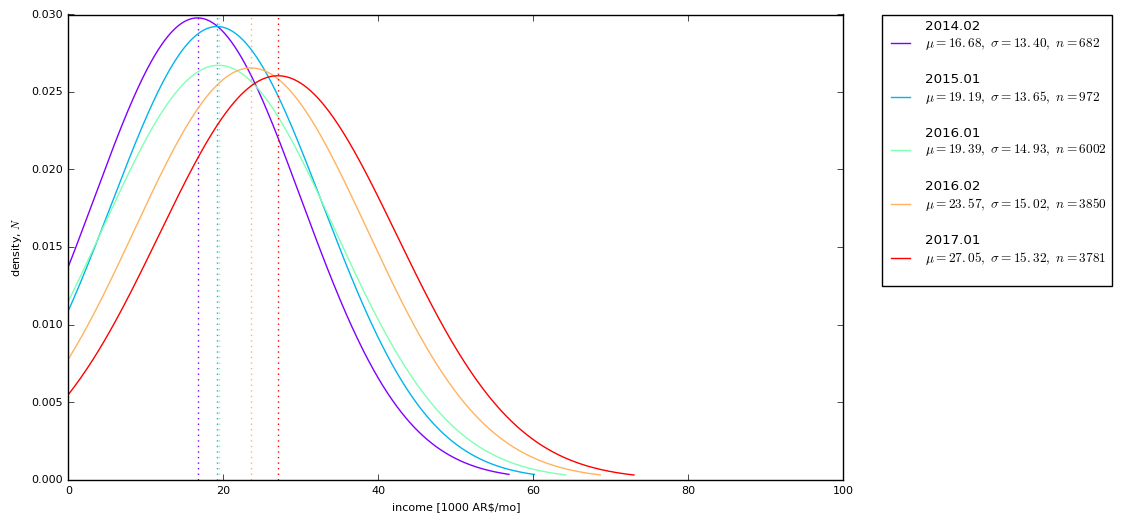

In [232]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
plt.xlim(0,100)
for i, period in enumerate(periods):
    dft = df[df.period.str.contains(period)]
    mu, sigma, t, d, s = getPlotSalarySeries(dft.salary)
    plt.plot(t, sps.norm.pdf(t, mu, sigma), label=period + '\n$\mu=%.2f,\ \sigma=%.2f,\ n=%d$\n' % (mu, sigma, len(s)), ls='-', c=colors[i])
    plt.axvline(x=mu, ls=':', c=colors[i])
plt.xlabel('income [1000 AR$/mo]'); plt.ylabel('density, $N$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Interactive Dashboard

The following graphic has some controls that allows you to filter data and so, refresh the visualization compared to the probability denstiy functions of the entire dataset by period.

<IPython.core.display.Javascript object>


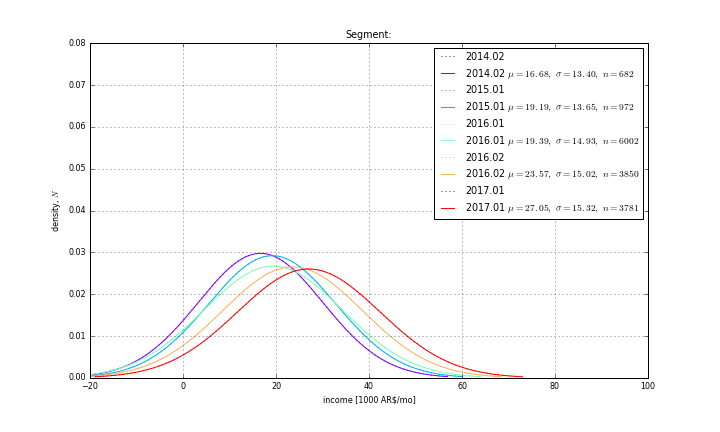

<IPython.core.display.Javascript object>


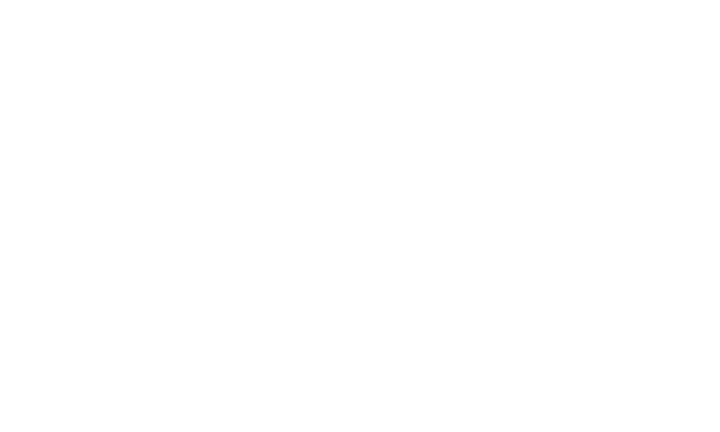

In [245]:
from IPython.display import clear_output
import ipywidgets as widgets

filters = ['role', 'yoe', 'yip']
i_filters = [{'name': r, 'i': i} for i, r in enumerate(filters)]
filters_opts = list(map(lambda r: list(df[r].unique()), filters))
filters_checkboxes = list(map(lambda r: widgets.Checkbox(value=False, description='Use '+r, name='use_'+r, disabled=False), filters))
filters_dropdowns = list(map(lambda r: widgets.Dropdown(options=filters_opts[r['i']], value=filters_opts[r['i']][0], name=r['name'], description=r['name']+':', disabled=not filters_checkboxes[r['i']].value), i_filters))

%matplotlib notebook
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})
fig, ax = plt.subplots()
ax.set_xlim(-20,100)
ax.set_ylim(0,0.08)
ax.set_xlabel('income [1000 AR$/mo]'); ax.set_ylabel('density, $N$')

def on_filters_change(change):
    for i in range(len(filters)):
        checkbox = filters_checkboxes[i]
        dropdown = filters_dropdowns[i]
        if change['owner'].name == checkbox.name:
            dropdown.disabled = not change['new']
            break
    plot_filtered_monthly_income()

def plot_filtered_monthly_income(change = None):
    plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 8})
    if not ax.lines:
        for i, period in enumerate(periods):
            dft = df[df.period.str.contains(period)]
            mu, sigma, t, d, s = getPlotSalarySeries(dft.salary)            
            ax.plot(t, sps.norm.pdf(t, mu, sigma), label=period, ls=':', c=colors[i])
            ax.plot(t, sps.norm.pdf(t, mu, sigma), label=period + ' $\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)), ls='-', c=colors[i])
    else:
        for i, period in enumerate(periods):
            dft = df[df.period.str.contains(period)]
            for dropdown in filters_dropdowns:
                dft = dft if dropdown.disabled else dft[dft[dropdown.name].str.contains(dropdown.value)]
            mu, sigma, t, d, s = getPlotSalarySeries(dft.salary)
            line = ax.lines[2*i+1]
            if len(dft) > 2:
                line.set_xdata(t)
                line.set_ydata(sps.norm.pdf(t, mu, sigma))
                line.set_label(period + ' $\mu=%.2f,\ \sigma=%.2f,\ n=%d$' % (mu, sigma, len(s)))
            else:
                line.set_xdata([]), line.set_ydata([])
    title = 'Segment:' + ''.join([
        '' if dropdown.disabled else ' %s: %s' % (dropdown.name, dropdown.value)
            for dropdown in filters_dropdowns])
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    fig.canvas.draw()

boxes = []
for i in range(len(filters_dropdowns)):
    filters_checkboxes[i].observe(on_filters_change, names='value')
    filters_dropdowns[i].observe(plot_filtered_monthly_income, names='value')
    boxes.append(widgets.Box([filters_checkboxes[i], filters_dropdowns[i]]))
    
plot_filtered_monthly_income()
widgets.Box(boxes)

## Stacks comparative analysis

Below, we will rank technologies by most frequent in the dataser.  We will exclude technologies with less than 100 samples in total -they are in most cases, isolated and not following a clear trend-.

From the resulting table we will plot the results in two ways:
1. First as a time-series comparative of the technologies by period, indicatin the $\mu$ median salary.
2. Secondly, as a scatter, having the salary median $\mu$ in the X axis, the standard deviation $\sigma$ in the Y axis and the amount of samples as the size of the dot.

In [218]:
dfst = pd.DataFrame(columns=['stack', 'count', 'mu', 'sigma', 'period', 'publish_date'])

i = 0
for period in periods:
    for j, row in dfs.iterrows():
        dfss = df.loc[ row['df_mask'] & (df['period'] == period) ]
        mu, sigma, t, d, s = getPlotSalarySeries(dfss['salary'])
        dfst.loc[i] = [row['stack'], len(dfss), mu, sigma, period, np.max(dfss['publish_date'])]
        i = i+1

# the ranking of technologies most frequent in the datasets order by median of salary
dfst = dfst.query('count >= 1').sort_values(by=['stack', 'period'], ascending=[0, 0])
dfst

,stack,count,mu,sigma,period,publish_date
64,windows,2844.0,25.242827,13.018835,2017.01,2017-02-01
48,windows,512.0,23.590430,9.715138,2016.02,2016-08-01
32,windows,831.0,19.829122,13.524452,2016.01,2016-02-01
16,windows,177.0,18.333898,11.019761,2015.01,2015-09-01
0,windows,135.0,14.777037,5.476386,2014.02,2015-01-01
66,vmware,991.0,28.717760,15.052373,2017.01,2017-02-01
50,vmware,340.0,25.225588,12.046870,2016.02,2016-08-01
34,vmware,533.0,20.660225,10.295920,2016.01,2016-02-01
18,vmware,7.0,15.085714,6.514912,2015.01,2015-09-01
2,vmware,11.0,19.154545,7.522858,2014.02,2015-01-01


## Median salary of the most frequent technologies in time

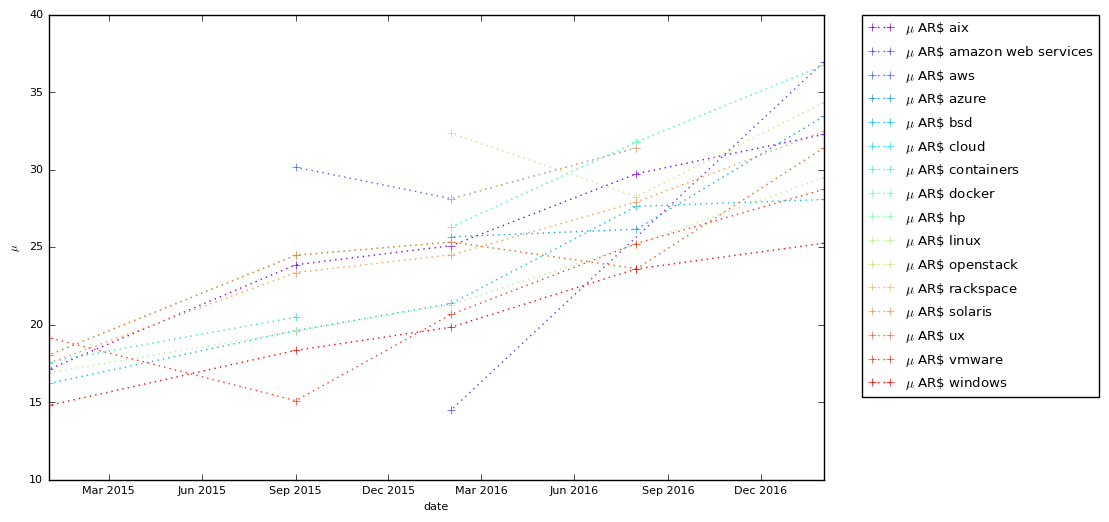

In [241]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 8})

trending_stacks = np.unique(dfts['stack'])
fullcolors = cm.rainbow(np.linspace(0, 1, len(trending_stacks)))
for i, stack in enumerate(trending_stacks):
    dfp = dfst.query('stack == @stack')
    plt.plot(dfp['publish_date'], dfp['mu'], '+', label='$\mu$ AR\$ %s' % stack, ls=':', c=fullcolors[i])
    plt.xlabel('date'); plt.ylabel('$\mu$')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
display(md('## Median salary of the most frequent technologies in time'))

## Scatter of technologies by median, dispersion, frequency and time

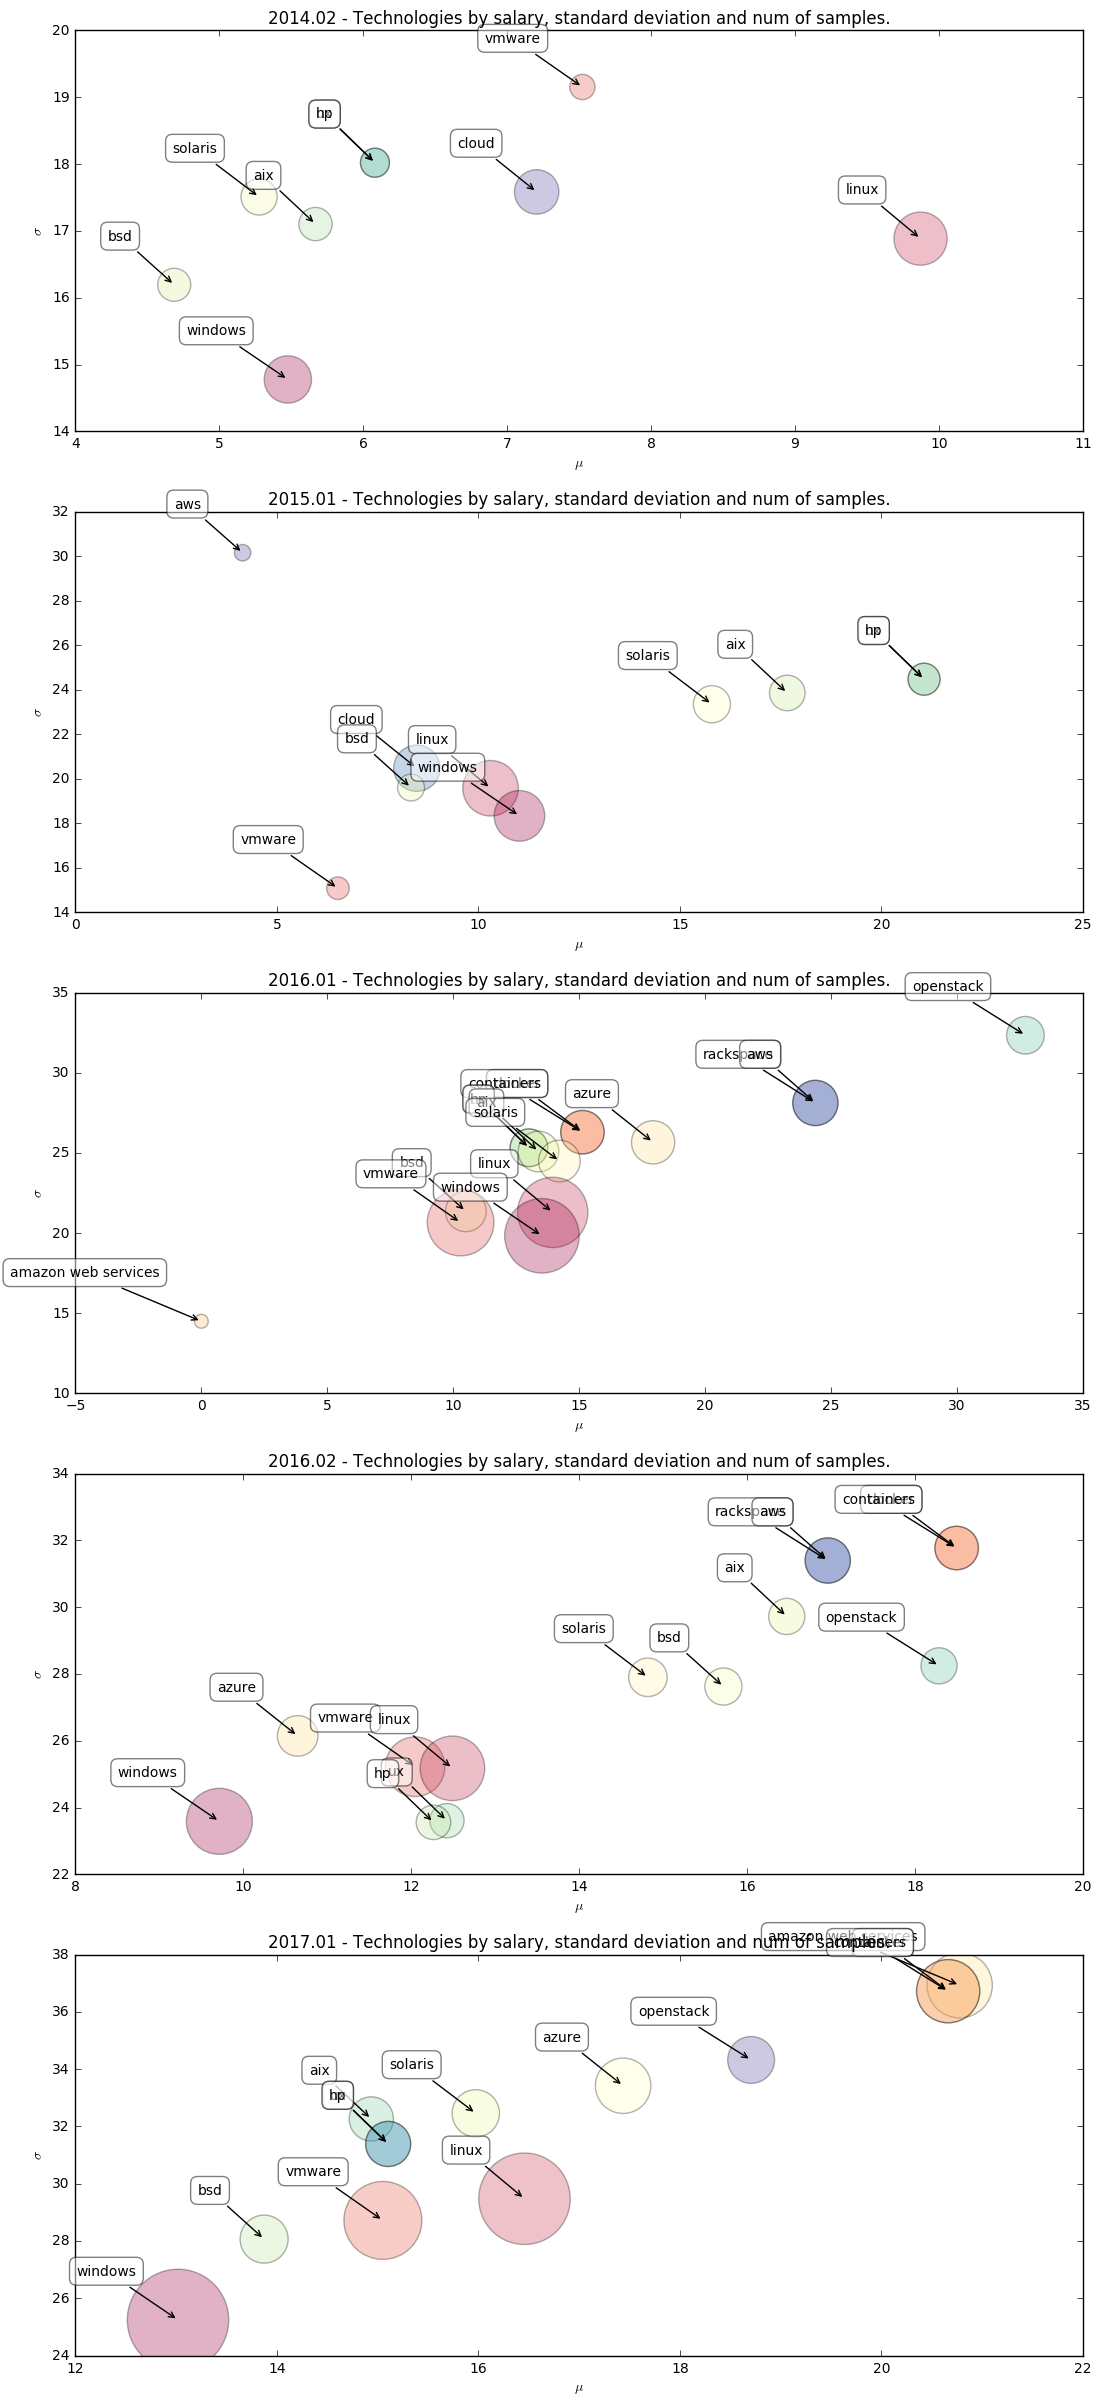

In [243]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (13.0, 30.0), 'font.size': 10})

fig, ax = plt.subplots(len(periods), 1)
for i, period in enumerate(periods):
    ## plot only the top ranked technologies in terms of salary for the period sample
    dftss = dfst.query("@period == period").sort_values(by=['mu', 'sigma'], ascending=[0, 0])[:30]
    ax[i].scatter(
        dftss['sigma'], dftss['mu'], marker='o', c=dftss.index, s=100*dftss['count']**(1/2), alpha=0.3,
        cmap=plt.get_cmap('Spectral'))

    for label, x, y in zip(dftss['stack'], dftss['sigma'], dftss['mu']):
        ax[i].annotate(
            label,
            xy=(x, y), xytext=(-30, 30),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    ax[i].set_xlabel('$\mu$'); ax[i].set_ylabel('$\sigma$')
    ax[i].set_title('%s - Technologies by salary, standard deviation and num of samples.' % period)
    fig.canvas.draw()
display(md('## Scatter of technologies by median, dispersion, frequency and time'))